In [1]:
import cv2
import numpy as np
import torch
import pandas as pd
import traceback
from datetime import datetime
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler, SubsetRandomSampler
import time
import os
import collections
from efficientnet.model import EfficientNet
from torchvision import transforms, models
from efficientnet.utils import round_filters, efficientnet
import torch.nn as nn
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomRotate90, Normalize, Flip, OneOf, Compose, Resize, Transpose
)
from catalyst.contrib.schedulers import OneCycleLR, ReduceLROnPlateau, StepLR, MultiStepLR
from catalyst.dl.experiment import SupervisedExperiment
from catalyst.dl.runner import SupervisedRunner
from catalyst.dl.callbacks import EarlyStoppingCallback, AccuracyCallback, F1ScoreCallback, ConfusionMatrixCallback, MixupCallback
from catalyst.dl.core.state import RunnerState
from catalyst.dl.core import MetricCallback
from catalyst.dl.callbacks import CriterionCallback
from sklearn.model_selection  import train_test_split
from typing import List
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Class for random patch augmentation
class RandomPatch(object):
    def __init__(self):
        pass

    def __call__(self, image):
        image_aug = image
        xs = np.random.randint(image_aug.shape[1], size=8)
        ys = np.random.randint(image_aug.shape[0], size=8)
        ws = np.random.randint(60, size=8)
        hs = np.random.randint(60, size=8)
        cs = np.random.randint(255, size=8)

        for x, y, w, h, c in zip(xs, ys, ws, hs, cs):
            cv2.rectangle(image_aug, (x, y), (x + w, y + h), (int(c), int(c), int(c)), -1)

        return image_aug
    
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1, img2, img3], axis=-1)
        #         print(img.shape)
        return img


def preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    blurred = cv2.GaussianBlur(image, (0, 0), 10)
    image = cv2.addWeighted(image, 4, blurred, -4, 128)
    return cv2.resize(image, (224, 224))


# Convert dataset file into proper form for training
class DiabeticDataset(Dataset):
    def __init__(self, dataset_path, labels, ids, transform, albumentations_tr, shuffle=True):
        self.labels = labels
        self.ids = ids
        self.shuffle = shuffle
        self.dataset_path = dataset_path
        self.albumentations_tr = albumentations_tr
        self.transform = transform
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        imid = self.ids[index]
        image = cv2.imread(os.path.join(self.dataset_path, imid + '.png'))
        image = preprocessing(image)

        if self.albumentations_tr:
            augmented = self.albumentations_tr(image=image)
            image = augmented['image']
        # cv2.imwrite(example[0] + '.png', image)
        image = image / 255.
        # image = np.expand_dims(image, axis=2)
        target = self.labels[index]
        return torch.from_numpy(image.transpose((2, 0, 1))).float(), torch.tensor(np.expand_dims(target,0)).float()
    
def calculate_weights(dataset):
    """
    Calculate weights of classes in dataset
    :param labels: list of files with parsed data
    :return: weights of classes
    """

    classes = {'NoDR': 0, 'Mild': 0, 'Moderate': 0, 'Severe': 0, 'Proliferative': 0}
    seq_type = []
    seq_weight = []
    for example in dataset:
        stage = example[1]
        if stage == '0':
            classes['NoDR'] += 1
            seq_type.append('NoDR')
        elif stage == '1':
            classes['Mild'] += 1
            seq_type.append('Mild')
        elif stage == '2':
            classes['Moderate'] += 1
            seq_type.append('Moderate')
        elif stage == '3':
            classes['Severe'] += 1
            seq_type.append('Severe')
        elif stage == '4':
            classes['Proliferative'] += 1
            seq_type.append('Proliferative')

    for i in classes.keys():
        classes[i] = 1 / classes[i]

    for type_img in seq_type:
        seq_weight.append(classes[type_img])

    return seq_weight

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

class CutmixCallback(CriterionCallback):
    """
    Callback to do mixup augmentation.
    Paper: https://arxiv.org/abs/1710.09412
    Note:
        MixupCallback is inherited from CriterionCallback and
        does its work.
        You may not use them together.
    """

    def __init__(
        self,
        fields: List[str] = ("features", ),
        alpha=1.0,
        on_train_only=True,
        **kwargs
    ):
        """
        Args:
            fields (List[str]): list of features which must be affected.
            alpha (float): beta distribution a=b parameters.
                Must be >=0. The more alpha closer to zero
                the less effect of the mixup.
            on_train_only (bool): Apply to train only.
                As the mixup use the proxy inputs, the targets are also proxy.
                We are not interested in them, are we?
                So, if on_train_only is True, use a standard output/metric
                for validation.
        """
        assert len(fields) > 0, \
            "At least one field for MixupCallback is required"
        assert alpha >= 0, "alpha must be>=0"

        super().__init__(**kwargs)

        self.on_train_only = on_train_only
        self.fields = fields
        self.alpha = alpha
        self.lam = 1
        self.index = None
        self.is_needed = True

    def on_loader_start(self, state: RunnerState):
        self.is_needed = not self.on_train_only or \
            state.loader_name.startswith("train")

    def on_batch_start(self, state: RunnerState):
        if not self.is_needed:
            return

        if self.alpha > 0:
            self.lam = np.random.beta(self.alpha, self.alpha)
        else:
            self.lam = 1

        self.index = torch.randperm(state.input[self.fields[0]].shape[0])
        self.index.to(state.device)

        for f in self.fields:
            bbx1, bby1, bbx2, bby2 = rand_bbox(state.input[f].size(), self.lam)
            state.input[f][:, :, bbx1:bbx2, bby1:bby2] = state.input[f][self.index, :, bbx1:bbx2, bby1:bby2]
            

    def _compute_loss(self, state: RunnerState, criterion):
        if not self.is_needed:
            return super()._compute_loss(state, criterion)

        pred = state.output[self.output_key]
        y_a = state.input[self.input_key]
        y_b = state.input[self.input_key][self.index]

        loss = self.lam * criterion(pred, y_a) + \
            (1 - self.lam) * criterion(pred, y_b)
        return loss

In [3]:
def quadratic_weighted_kappa(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    threshold: float = None,
    activation: str = None
):
    """
    Args:
        outputs (torch.Tensor): A list of predicted elements
        targets (torch.Tensor):  A list of elements that are to be predicted
        activation (str): An torch.nn activation applied to the outputs.
            Must be one of ["none", "Sigmoid", "Softmax2d"]
    Returns:
        float: quadratic kappa score
    """
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    outputs_clipped = list()
    outputs_clipped = np.rint(outputs)
    outputs_clipped[outputs_clipped<0] = 0
    outputs_clipped[outputs_clipped>4] = 4
    #for o in outputs:
    #    if o <= 0.5:
    #        outputs_clipped.append(0)
    #    if 0.5 > o <= 1.5:
    #        outputs_clipped.append(1)
    #    if 1.5 < o <= 2.5:
    #        outputs_clipped.append(2)
    #    if 2.5 < o <= 3.5:
    #        outputs_clipped.append(3)
    #    if o > 3.5:
    #        outputs_clipped.append(4)      
    #simple clip of outputs
    score = cohen_kappa_score(outputs_clipped, targets, weights='quadratic')
    return score
class QuadraticKappScoreMetricCallback(MetricCallback):
    """
    F1 score metric callback.
    """

    def __init__(
        self,
        input_key: str = "targets",
        output_key: str = "logits",
        prefix: str = "qkappa_score",
        activation: str = None
    ):
        """
        Args:
            input_key (str): input key to use for iou calculation
                specifies our ``y_true``.
            output_key (str): output key to use for iou calculation;
                specifies our ``y_pred``
            activation (str): An torch.nn activation applied to the outputs.
                Must be one of ['none', 'Sigmoid', 'Softmax2d']
        """

        super().__init__(
            prefix=prefix,
            metric_fn=quadratic_weighted_kappa,
            input_key=input_key,
            output_key=output_key,
            activation=activation
        )
        
def mean_squared_error_callback(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    threshold: float = None,
    activation: str = None
):
    """
    Args:
        outputs (torch.Tensor): A list of predicted elements
        targets (torch.Tensor):  A list of elements that are to be predicted
        activation (str): An torch.nn activation applied to the outputs.
            Must be one of ["none", "Sigmoid", "Softmax2d"]
    Returns:
        float: quadratic kappa score
    """

    outputs = outputs.cpu().detach().numpy()
    score = mean_squared_error(outputs, targets.detach().cpu().numpy())
    return score
class MSECallback(MetricCallback):
    """
    F1 score metric callback.
    """

    def __init__(
        self,
        input_key: str = "targets",
        output_key: str = "logits",
        prefix: str = "mse_score",
        activation: str = None
    ):
        """
        Args:
            input_key (str): input key to use for iou calculation
                specifies our ``y_true``.
            output_key (str): output key to use for iou calculation;
                specifies our ``y_pred``
            activation (str): An torch.nn activation applied to the outputs.
                Must be one of ['none', 'Sigmoid', 'Softmax2d']
        """

        super().__init__(
            prefix=prefix,
            metric_fn=mean_squared_error_callback,
            input_key=input_key,
            output_key=output_key,
            activation=activation
        )
def mean_absolute_error_callback(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    threshold: float = None,
    activation: str = None
):
    """
    Args:
        outputs (torch.Tensor): A list of predicted elements
        targets (torch.Tensor):  A list of elements that are to be predicted
        activation (str): An torch.nn activation applied to the outputs.
            Must be one of ["none", "Sigmoid", "Softmax2d"]
    Returns:
        float: quadratic kappa score
    """

    outputs = outputs.cpu().detach().numpy()
    score = mean_absolute_error(outputs, targets.detach().cpu().numpy())
    return score
class MAECallback(MetricCallback):
    """
    F1 score metric callback.
    """

    def __init__(
        self,
        input_key: str = "targets",
        output_key: str = "logits",
        prefix: str = "mae_score",
        activation: str = None
    ):
        """
        Args:
            input_key (str): input key to use for iou calculation
                specifies our ``y_true``.
            output_key (str): output key to use for iou calculation;
                specifies our ``y_pred``
            activation (str): An torch.nn activation applied to the outputs.
                Must be one of ['none', 'Sigmoid', 'Softmax2d']
        """

        super().__init__(
            prefix=prefix,
            metric_fn=mean_absolute_error_callback,
            input_key=input_key,
            output_key=output_key,
            activation=activation
        )

In [4]:
def aug_train(p=1): 
    return Compose([OneOf([
                        HorizontalFlip(), 
                        VerticalFlip(), 
                        RandomRotate90(), 
                        Transpose()],p=0.25)
                    ], p=p)

In [5]:
batch_size = 12
model = EfficientNet.from_pretrained('efficientnet-b0')
w, d, s, p = 1.0, 1.0, 224, 0.2
blocks_args, global_params = efficientnet(
    width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
out_channels = round_filters(1280, global_params)
model._fc = nn.Linear(out_channels, 1)

Loaded pretrained weights for efficientnet-b0


In [6]:
pretrained = torch.load('logs/efficient_net_log_strong_aug_wd01/checkpoints/best.pth')
model.load_state_dict(pretrained['model_state_dict'])
model.eval()
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [7]:
test = pd.read_csv('../data/test.csv')
submit = pd.read_csv('../data/sample_submission.csv')

In [8]:
def preprocess_image(image_id, imdir):
    image = cv2.imread(os.path.join(imdir, image_id + '.png'))
    image = preprocessing(image)
    image = image / 225.0
    image = np.rollaxis(image, -1)    
    image = np.expand_dims(image, 0)
    image = torch.tensor(image, dtype=torch.float32).cuda()
    return image 

In [ ]:
predicted_reg  = list()
with torch.no_grad():
    for i, name in tqdm(enumerate(submit['id_code']), total=len(submit['id_code'])):
        image = preprocess_image(name, '../data/test')
        predicted_reg += [model(image)[0][0].cpu().numpy()]

 22%|██▏       | 431/1928 [00:41<01:39, 14.98it/s]

In [20]:
predicted_reg = np.array(predicted_reg)
predicted_reg[predicted_reg<0] = 0
predicted_reg[predicted_reg>4] = 4
predicted_clipped = list()
for idx in range(len(predicted_reg)):
    if predicted_reg[idx]<0.5:
        predicted_clipped.append(0)
    elif  predicted_reg[idx]>=0.5 and predicted_reg[idx]<1.5:
        predicted_clipped.append(1)
    elif  predicted_reg[idx]>=1.5 and predicted_reg[idx]<2.5:
        predicted_clipped.append(2)
    elif  predicted_reg[idx]>=2.5 and predicted_reg[idx]<3.5:
        predicted_clipped.append(3)
    elif  predicted_reg[idx]>=3.5:
        predicted_clipped.append(4)
assert(len(predicted_clipped)==len(predicted_reg))

(array([123.,   0., 580.,   0.,   0., 971.,   0., 253.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

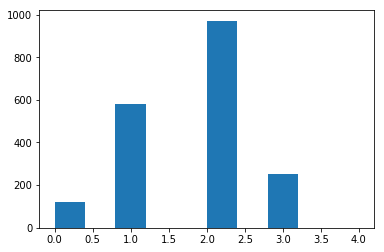

In [21]:
plt.hist(predicted_clipped)

In [22]:
public_submission = pd.read_csv('../data/submission_from_kaggle.csv')

In [23]:
submit['diagnosis'] = predicted_clipped

In [24]:
np.corrcoef(submit['diagnosis'], public_submission['diagnosis'])

array([[1.        , 0.58340919],
       [0.58340919, 1.        ]])

In [100]:
submit['diagnosis_public_kernel']= public_submission['diagnosis']

In [101]:
submit.groupby(['diagnosis_public_kernel', 'diagnosis']).size().unstack()

diagnosis,0,1,2,3,4
diagnosis_public_kernel,,,,,
0,251.0,71.0,NaN,NaN,NaN
1,45.0,129.0,18.0,NaN,NaN
2,11.0,181.0,762.0,128.0,NaN
3,NaN,4.0,89.0,191.0,16.0
4,NaN,NaN,NaN,15.0,17.0


In [80]:
submit.groupby(['diagnosis_public_kernel', 'diagnosis']).size().unstack()

diagnosis,0,1,2,3,4
diagnosis_public_kernel,,,,,
0,236.0,86.0,NaN,NaN,NaN
1,40.0,142.0,10.0,NaN,NaN
2,10.0,346.0,679.0,47.0,NaN
3,NaN,4.0,175.0,114.0,7.0
4,NaN,NaN,1.0,17.0,14.0
